In [1]:
from pandas import read_csv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
IMAGE_SIZE = 96

Чтение данных (пока нужен только training.csv)

In [4]:
#id_lookup = read_csv("../IdLookupTable.csv")
#sample_submission = read_csv("../SampleSubmission.csv")
#test = read_csv("../test.csv")
training = read_csv("../training.csv")

Изображение записано в виде строки чисел от 0 до 255, разделенных пробелом. Преобразуем эту строку к массиву чисел 0-255

In [5]:
training.Image = training.Image.apply(lambda img: np.fromstring(img, sep=' '))

Отбрасывание примеров, в которых заполнены поля не для всех признаков. Из ~7000 изображение остается ~2000

In [6]:
training = training.dropna()
#training = training.fillna(-1)

labels - правильные координаты признаков, используемые для обучения сети

In [7]:
labels = np.array([])
for key_name in training.columns.values[:-1]:
    labels = np.append(labels, np.array(training[key_name]))
labels = labels.reshape(training.shape[1]-1, len(training.Image)).T

Для примера выведем на экран размерность массива признаков в виде (кол-во строк; кол-во признаков для одного изображения).
И также выведем признаки для первого изображения

In [8]:
print labels.shape
print labels[0]

(2140, 30)
[ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519
  39.64742256  73.13034586  39.96999699  36.35657143  37.3894015
  23.45287218  37.3894015   56.95326316  29.03364812  80.22712782
  32.22813835  40.22760902  29.0023218   16.35637895  29.64747068
  44.42057143  57.06680301  61.19530827  79.97016541  28.61449624
  77.38899248  43.3126015   72.93545865  43.13070677  84.48577444]


Функция для вывода изображения на экран

In [9]:
def print_image(data):
    img = [[x]*3 for x in data]
    img = np.reshape(img, (96,96,3))
    plt.imshow(img)

Функция для печати изображения с нанесенными признаками

In [10]:
def test_point(img_ind, a, b):
    plt.xlim([0, 96])
    plt.ylim([96, 0])
    f = teX[img_ind].reshape(96*96)
    print_image(f)
    for i in range(length):
        plt.plot(a[img_ind][i][0],a[img_ind][i][1], 'r*')
        plt.plot(b[img_ind][i][0],b[img_ind][i][1], 'bo')
    plt.show()

Функции для масштабирование признаков в прямую ((0; 96) -> (-1; 1)) и обратную сторону

In [11]:
def scale(x):
    return (x - 48) / 48
    #return x / 96.0
def unscale(x):
    return x * 48 + 48
    #return x * 96.0

Объявление массива образцов для обучения и тестирования, печать его размерности и первого элемента

In [71]:
#t_samples = np.array([np.copy(img) for img in training.Image[0:1000].apply(lambda x: x / 255.0)])
t_samples = np.array([np.copy(img) for img in training.Image[:2048].apply(lambda x: x / 255.0)])
print t_samples.shape
print t_samples[0]

(2048, 9216)
[ 0.93333333  0.9254902   0.92941176 ...,  0.2745098   0.29411765
  0.35294118]


Масштабирование признаков и печать первого элемента до масштабирования и после

In [72]:
print labels[0]
t_labels = scale(labels)
print t_labels[0]

[ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519
  39.64742256  73.13034586  39.96999699  36.35657143  37.3894015
  23.45287218  37.3894015   56.95326316  29.03364812  80.22712782
  32.22813835  40.22760902  29.0023218   16.35637895  29.64747068
  44.42057143  57.06680301  61.19530827  79.97016541  28.61449624
  77.38899248  43.3126015   72.93545865  43.13070677  84.48577444]
[ 0.37569925 -0.18745263 -0.37027068 -0.24121504  0.24129323 -0.17401203
  0.52354887 -0.16729173 -0.24257143 -0.22105414 -0.5113985  -0.22105414
  0.18652632 -0.39513233  0.6713985  -0.32858045 -0.16192481 -0.39578496
 -0.65924211 -0.38234436 -0.07457143  0.18889173  0.27490226  0.66604511
 -0.40386466  0.61227068 -0.09765414  0.51948872 -0.10144361  0.7601203 ]


Функция для инициализации весов (задаются размерности матриц (тензоров))

In [14]:
def init_weights(shape):
    #return tf.Variable(tf.random_normal(shape, stddev=0.01))
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))

Задание размеров обучающей и тестирующей выборки и вывод их на экран

In [20]:
full_volume = len(t_samples)
train_volume = int(full_volume * 0.875)
test_volume = full_volume - train_volume
print "%d\n%d\n%d" % (full_volume, train_volume, test_volume)

2048
1792
256


Задание обучающей и тестирующей выборки

In [73]:
trX = np.array(t_samples[:train_volume], dtype=np.float)
teX = np.array(t_samples[train_volume:full_volume], dtype=np.float)
trY = np.array(t_labels[:train_volume], dtype=np.float)
teY = np.array(t_labels[train_volume:full_volume], dtype=np.float)

trX = trX.reshape(-1, 96, 96, 1)  # 96x96x1 input img
teX = teX.reshape(-1, 96, 96, 1)  # 96x96x1 input img

Модель сверточной нейронной сети. p_keep_conv, p_keep_hidden - вероятности сохранения (не отбрасывания) нейрона при обучении после применения dropout

In [84]:
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden, show_shapes=False):
    
    l1 = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1 shape=(?, 96, 96, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1_shape = l1.get_shape()
    l1 = tf.nn.max_pool(l1, ksize=[1, 2, 2, 1],              # l1 shape=(?, 48, 48, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2 = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 48, 48, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2_shape = l2.get_shape()
    l2 = tf.nn.max_pool(l2, ksize=[1, 2, 2, 1],              # l2 shape=(?, 24, 24, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)
    
    l3 = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 24, 24, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3_shape = l3.get_shape()
    l3 = tf.nn.max_pool(l3, ksize=[1, 3, 3, 1],              # l3 shape=(?, 8, 8, 128)
                        strides=[1, 3, 3, 1], padding='SAME')
    l3_after_maxpool_shape = l3.get_shape()
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    #l4 = tf.nn.tanh(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)
    
    #l5 = tf.nn.relu(tf.matmul(l4, w5))
    #l5 = tf.nn.dropout(l5, p_keep_hidden)

    y = tf.matmul(l4, w_o)
    #pyx = tf.nn.tanh(tf.matmul(l4, w_o))
    
    if show_shapes:
        print 'X: ', X.get_shape()
        print 'l1: ', l1_shape
        print 'l1 after max pool: ', l1.get_shape()
        print 'l2: ', l2_shape
        print 'l2 after max pool: ', l2.get_shape()
        print 'l3: ', l3_shape
        print 'l3 after max pool: ', l3_after_maxpool_shape
        print 'w4.get_shape().as_list()[0]: ', w4.get_shape().as_list()[0]
        print 'l3 after reshape: ', l3.get_shape()
        print 'l4: ', l4.get_shape()
        #print 'l5: ', l5.get_shape()
        print 'pyx: ', y.get_shape()
    return y

Объявление placeholder'ов и инициализация весов

In [85]:
X = tf.placeholder("float", [None, 96, 96, 1], name="X")
Y = tf.placeholder("float", [None, training.shape[1]-1], name="Y")

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 8 * 8, 625]) # Fully connected 128 * 4 * 4 inputs, 625 outputs
#w5 = init_weights([2000, 625]) # FC 2000 input, 625 output
w_o = init_weights([625, training.shape[1]-1])         # FC 625 inputs, 2 outputs (labels)

p_keep_conv = tf.placeholder("float", name="p_keep_conv")
p_keep_hidden = tf.placeholder("float", name="p_keep_hidden")

pred = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden, show_shapes=False)

Задание eps для проверки точности работы нейросети, а также размеров одновременно подаваемых образцов для обучения (они подаются нейросети, вычисляется средняя ошибка для всех этих образцов и только после этого меняются веса) и тестирования

In [45]:
eps = 0.01
batch_size = 128

После каждой эпохи обучения скорость обучения будет уменьшаться

In [86]:
global_step = tf.Variable(1, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step * batch_size,
                                           train_volume, 0.96, staircase=True)

Задание вычислительных узлов графа tensorflow
+ Стоимость - среднеквадратичная ошибка
+ Метод обучения - RMSProp

In [87]:
#cost = (tf.nn.l2_loss(py_x - Y))
cost = tf.reduce_mean(tf.reduce_sum(tf.square(pred - Y)))

train_op = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost, global_step=global_step)
#train_op = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)

predict_op = pred

Функции для оценки точности. Проверяется что все сравниваемые элементы отличаются не более чем на eps

In [54]:
def eq_eps(y, yl):
    return np.abs(y - yl) < eps

def all_eq_eps(y, yl):
    return (all(eq_eps(yc, ylc)) for yc, ylc in zip(y, yl))

Запуск обучения.
* Создание сессии tensorflow
* Инициализация переменных
* Задание кол-ва эпох
* Разделение обучающей выборки на равные части (batch) размером batch_size
* Каждую эпоху:
  - Для каждого batch
    + Запустить обучение на этой части выборки
  - Запустить сеть на тестирующей выборке
  - Вычислить процент правильных результатов
  - Напечатать результат

In [63]:
sess = tf.Session()

In [88]:
sess.run(tf.initialize_all_variables())

EPOCHS = 10

training_batch = zip(range(0, train_volume, batch_size),
                         range(batch_size, train_volume, batch_size))

for i in range(EPOCHS):
    for start, end in training_batch:
        
        feed_dict={X: trX[start:end], Y: trY[start:end], p_keep_conv: 0.8, p_keep_hidden: 0.5}
        _, cst, cur_learning_rate = sess.run([train_op, cost, learning_rate], feed_dict=feed_dict)

    y = sess.run(predict_op, feed_dict={X: teX, p_keep_conv: 1.0, p_keep_hidden: 1.0})

    acc = [eq_eps(a,b) for (a,b) in zip(teY, y)]
    accuracy = np.mean(acc)
    print "Epoch: %d;   Cost: %7.3f;   Accuracy: %.0f%%;   Learning rate: %.5f" % (i, cst, accuracy*100, cur_learning_rate)

Epoch: 0;   Cost: 580.263;   Accuracy: 1%;   Learning rate: 0.00100
Epoch: 1;   Cost:  91.938;   Accuracy: 5%;   Learning rate: 0.00096
Epoch: 2;   Cost: 155.783;   Accuracy: 8%;   Learning rate: 0.00092
Epoch: 3;   Cost:  71.272;   Accuracy: 4%;   Learning rate: 0.00088
Epoch: 4;   Cost: 108.441;   Accuracy: 8%;   Learning rate: 0.00085
Epoch: 5;   Cost:  69.475;   Accuracy: 3%;   Learning rate: 0.00082
Epoch: 6;   Cost:  58.082;   Accuracy: 5%;   Learning rate: 0.00078
Epoch: 7;   Cost: 160.119;   Accuracy: 8%;   Learning rate: 0.00075
Epoch: 8;   Cost:  64.595;   Accuracy: 5%;   Learning rate: 0.00072
Epoch: 9;   Cost:  70.224;   Accuracy: 9%;   Learning rate: 0.00069


Запустить сеть на первых 10 изображениях из тестового множества. И отмасштабировать к (0; 96).

In [89]:
y = sess.run(predict_op, feed_dict={X: teX[0:10], p_keep_conv: 1.0, p_keep_hidden: 1.0})
a, b = unscale(y[0:10]), unscale(teY[0:10])

Вывести на экран результат работы сети (a) и правильный результат (b) для одного и того же изображения

In [90]:
print a[1]
print b[1]

[ 66.8396759   36.02679443  28.56633759  36.64585495  58.82346344
  37.65035248  75.10795593  36.73554993  36.75658035  37.44100189
  20.09881783  37.84521866  55.3082428   28.90834427  81.78010559
  29.11030769  39.33855438  28.92267227  13.04273987  30.29021835
  47.95310974  59.75370789  64.93389893  77.17131805  30.85299492
  77.68414307  49.25621414  74.37590027  49.11198807  84.48436737]
[ 67.45914619  36.85883376  29.1785432   36.99648165  58.47469558
  38.11271131  76.5862602   36.97028954  36.84530782  38.58639838
  20.82307483  38.37426068  54.18727591  33.2607453   84.47299019
  30.24947999  38.64637795  35.37209224  13.78797918  30.62467694
  43.94836069  64.11992358  68.1195102   83.01518367  36.08163265
  81.60065306  50.12767347  80.65763265  50.69844898  92.47020408]


Изменить размеры 

In [91]:
length = len(a[0]) / 2
a = a.reshape(10, length, 2)
b = b.reshape(10, length, 2)

Вывести на экран изображения с нанесением признаков (синий - правильные, красный - результат сети)

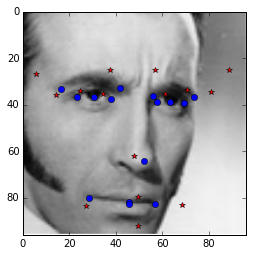

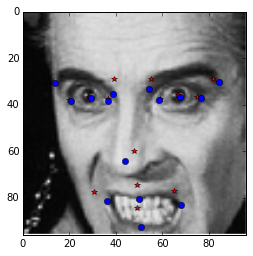

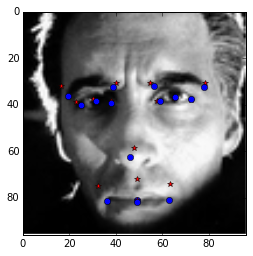

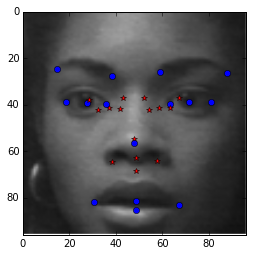

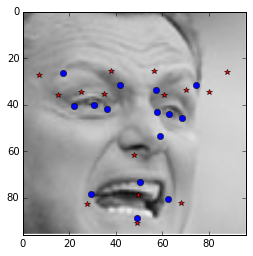

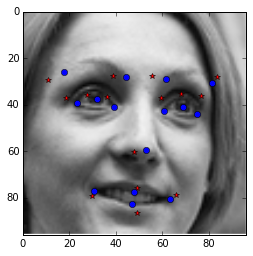

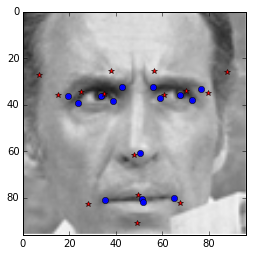

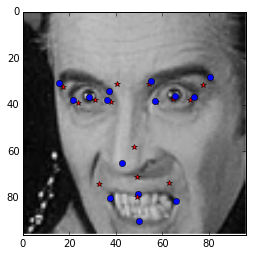

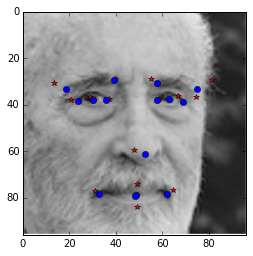

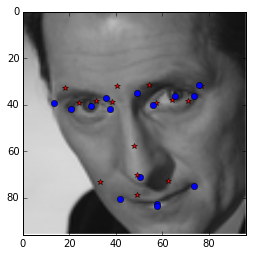

In [93]:
for i in range(10):
    test_point(i, a, b)

Вывести веса первого сверточного слоя ради интереса

In [94]:
print w.eval(session=sess)

[[[[  1.06160250e-02   1.73759386e-02   7.18647707e-03   8.46912339e-03
     -3.19966744e-03   3.10796150e-03   2.33948715e-02   1.31352674e-02
     -1.11970585e-03   8.96698143e-03  -1.77008694e-03   9.72431898e-03
      7.38274865e-03   1.29347863e-02  -1.23662734e-03  -2.67091393e-03
     -9.22673102e-03  -2.03163940e-02  -1.33165708e-02  -1.33040443e-03
      1.37314023e-02  -8.41799378e-03   1.17558716e-02   8.35728925e-03
     -5.14648343e-03  -2.44969456e-03  -1.42559288e-02  -1.05124693e-02
     -1.20644681e-02   2.83945929e-02  -2.31628842e-03   1.66973155e-02]]

  [[  1.09095322e-02  -1.44365923e-02   1.11847678e-02  -4.37812414e-03
      1.69326905e-02  -6.07915036e-03   1.05281649e-02   1.53096337e-02
      1.40868574e-02   1.46620851e-02  -1.11122336e-02   2.14962382e-02
     -3.43219173e-04  -2.14275718e-03   1.30049158e-02   3.85262398e-03
     -1.23208240e-02  -6.98952284e-03  -6.61926018e-03  -3.42234690e-03
      2.52529290e-02  -3.63372127e-03  -1.08634094e-02   1.31

Закрытие сессии tensorflow

In [95]:
sess.close()